# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знайомство з даними


## Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [21]:
df = pd.read_csv("/content/bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:

* season: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* yr: 0 - 2011, 1 - 2012
* mnth: від 1 до 12
* holiday: 0 – немає свята, 1 – є свято
* weekday: від 0 до 6
* workingday: 0 - неробочий день, 1 - робочий день
*weathersit: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* temp: температура у Цельсіях
* atemp: температура по відчуттям у Цельсіях
* hum: вологість
* windspeed(mph): швидкість вітру в милях на годину
* windspeed(ms): швидкість вітру в метрах за секунду
* cnt: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної cnt.

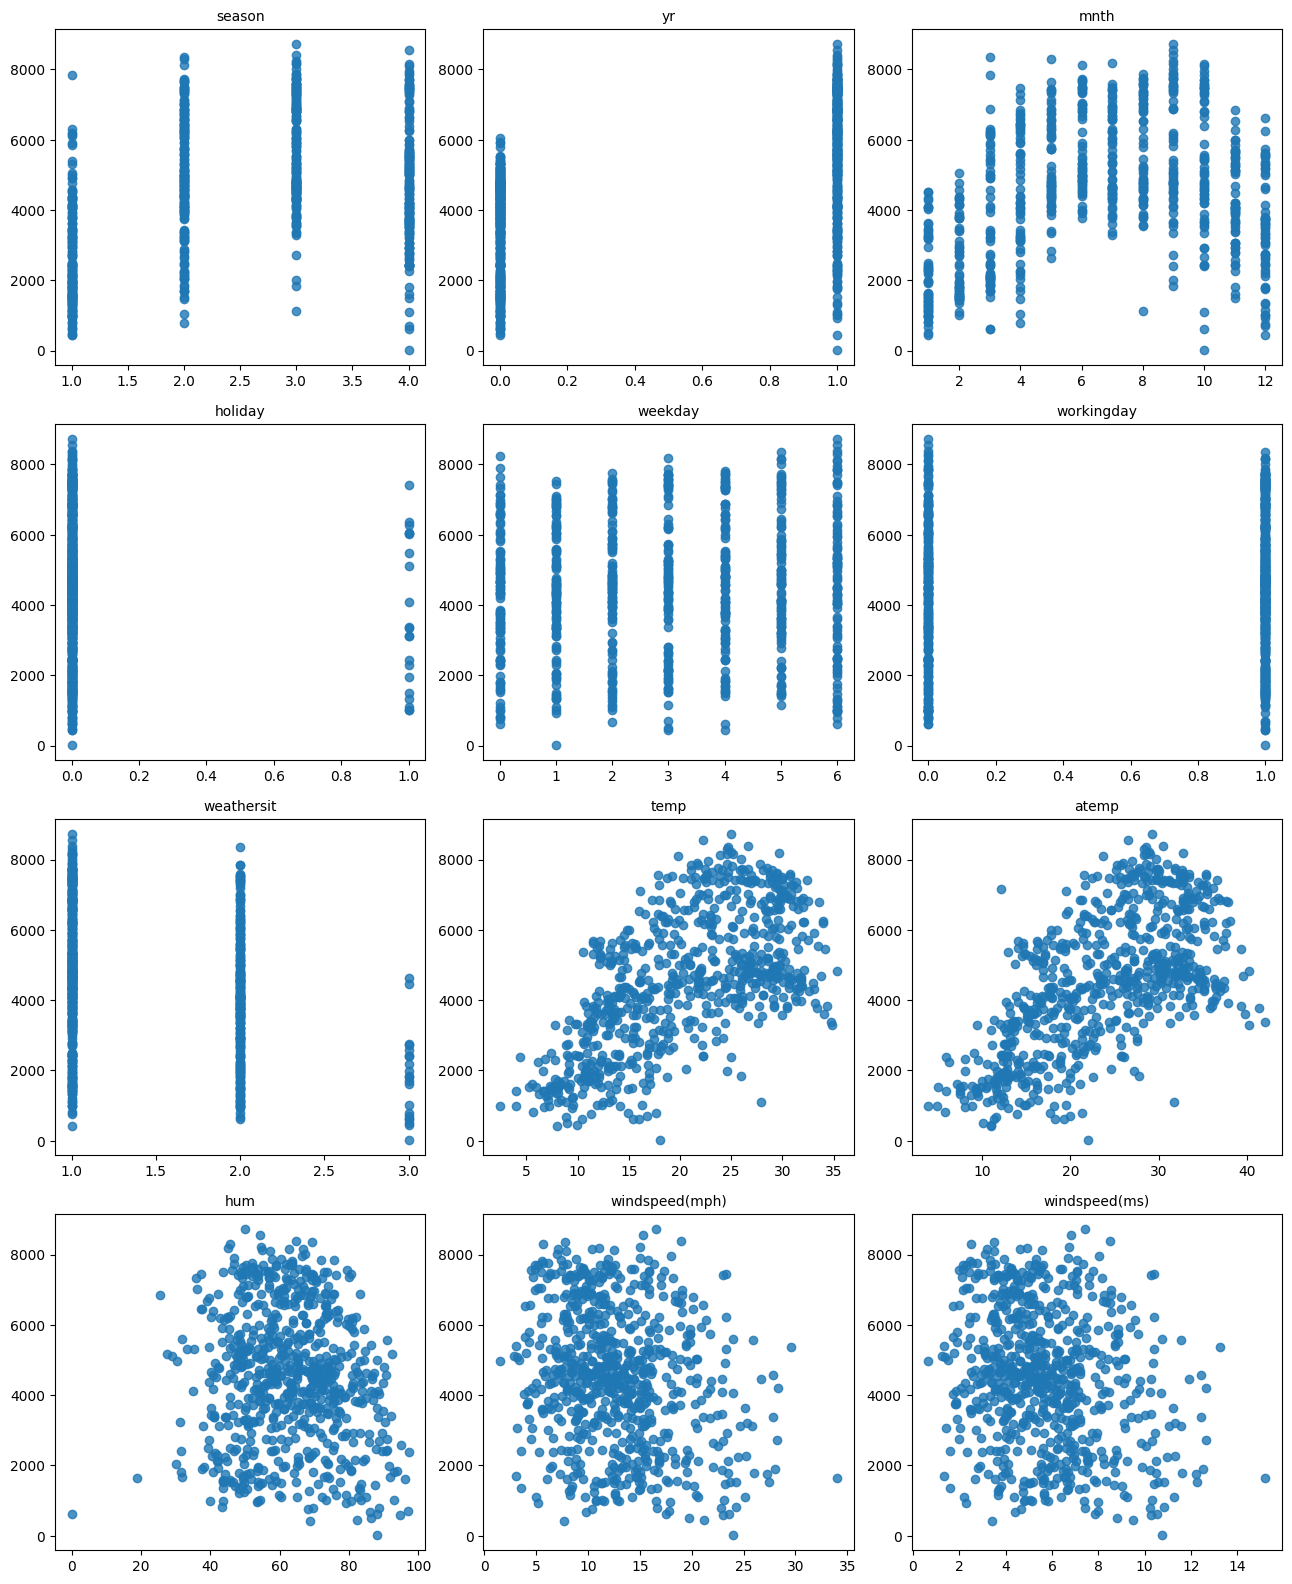

In [22]:
fig, axs = plt.subplots(4, 3, figsize=(13, 12))
fig.tight_layout()

order = [(a, b) for a in range(4) for b in range(3)]

# axs[0].plot([1, 2, 3, 4], [1, 2, 3, 4])
# plt.show()

for num, name in enumerate(df.columns[:-1]):
  axs[order[num]].scatter(df[name], df["cnt"], alpha=0.8)
  axs[order[num]].set_title(name, fontsize=10)
  plt.subplots_adjust(top=1.3)

## Питання:

1. Який характер залежності кількості прокатів від місяця?
2. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно

## Відповіді:

1. Чим далі від зимніх місяців (01, 02) і ближче до середини року (05, 06, 07, 08, 09), тим кількість прокатів зростає. Далі, ближче до осені-зими, спадає
2. holiday, workingday

## Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [23]:
# print(df.iloc[:, :-1])
df.iloc[:, :-1].corr()
df.corrwith(df["cnt"])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt за допомогою методу corr:

In [24]:
df.iloc[:, 7:].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

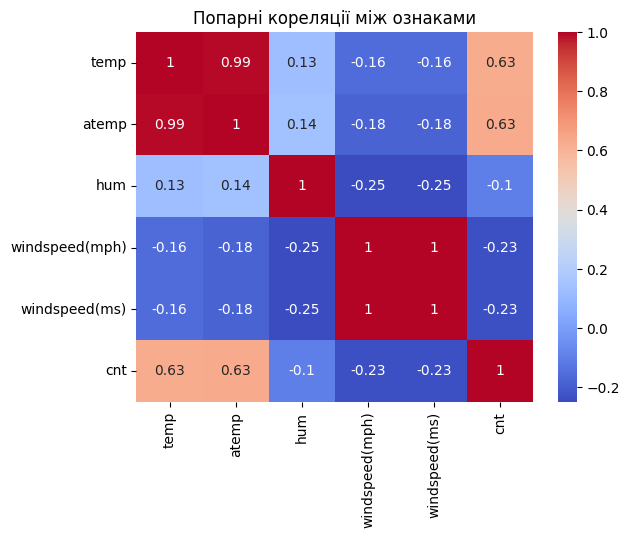

In [25]:
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap="coolwarm")
plt.title("Попарні кореляції між ознаками")
plt.show()

## Завдання 4

Виведіть середні ознаки

In [26]:
print(df.mean())

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [27]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [28]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [29]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній coef_ класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією zip, вбудованою в мову python. Назви ознак зберігаються у змінній df.columns.


In [30]:
reg_obj = LinearRegression().fit(X, y)
[i for i in zip(df.columns, reg_obj.coef_)]

[('season', 570.8637960129914),
 ('yr', 1021.9653779400622),
 ('mnth', -141.3017451148728),
 ('holiday', -86.7593446245368),
 ('weekday', 137.22506441350538),
 ('workingday', 56.391881775973005),
 ('weathersit', -330.2264620440312),
 ('temp', 367.48373260182126),
 ('atemp', 585.5493861188597),
 ('hum', -145.61430569885857),
 ('windspeed(mph)', 12457138390688.885),
 ('windspeed(ms)', -12457138390887.346)]

Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають __проблемою мультиколлінеарності__.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\lambda$. У першому випадку метод називається Lasso, а в другому --- Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з  $L_1$ и $L_2$-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [31]:
from sklearn.linear_model import Lasso, Ridge

lasso_l1 = Lasso().fit(X, y)
lasso_res = [i for i in zip(df.columns, lasso_l1.coef_)]
for cort in lasso_res:
  cor1, cor2 = cort
  print(cor1, cor2)

season 560.2416160308861
yr 1019.4634940657196
mnth -128.73062703678696
holiday -86.15278133371106
weekday 137.34789390496314
workingday 55.21237064135668
weathersit -332.3698569623487
temp 376.3632362096943
atemp 576.530793504555
hum -144.12915500348583
windspeed(mph) -197.1396894024843
windspeed(ms) -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-ругляризацією (клас Ridge) і виведіть ваги

In [32]:
ridge_l2 = Ridge().fit(X, y)
ridge_res = [i for i in zip(df.columns, ridge_l2.coef_)]
for cort in ridge_res:
  cor1, cor2 = cort
  print(cor1, cor2)

season 563.0645722520181
yr 1018.9483787875305
mnth -131.87332028247715
holiday -86.74609799709232
weekday 138.00511117871918
workingday 55.90311037506467
weathersit -332.34978849907367
temp 386.45788919190807
atemp 566.3470470600669
hum -145.07132729867195
windspeed(mph) -99.25944108179067
windspeed(ms) -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ нівелює ваги при деяких ознаках. Проспостерігаємо, як змінюються ваги, при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги в список `coefs_lasso`, а потім навчіть Ridge і запишіть ваги в список `coefs_ridge`' Конвертуйте отримані списки в `np.array`.

In [33]:
alphas = np.arange(1, 500, 50)

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for num, alpha in enumerate(alphas):
    lasso_l1 = Lasso(alpha=alpha).fit(X, y)
    # coefs_lasso.append(lasso_l1.coef_)
    coefs_lasso[num] = lasso_l1.coef_

for num, alpha in enumerate(alphas):
    ridge_l2 = Ridge(alpha).fit(X, y)
    # coefs_ridge.append(ridge_l2)
    coefs_ridge[num] = ridge_l2.coef_

print(coefs_lasso, coefs_ridge)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78775678e-08]
 [ 2.

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

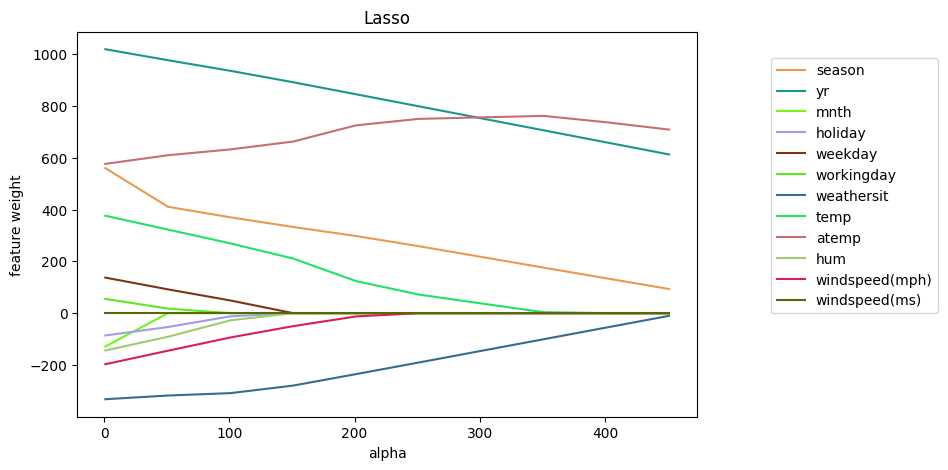

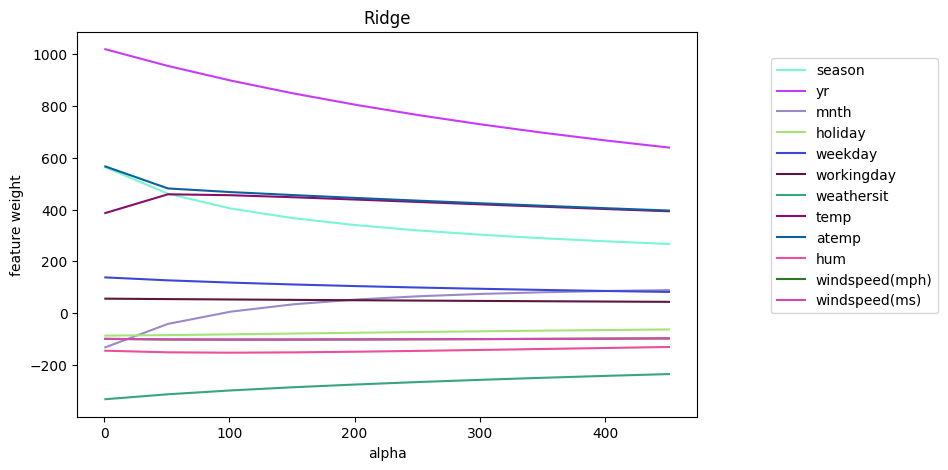

In [36]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
4. Який із регуляризаторів підійде для відбору неінформативних ознак?

## Відповіді:
1. Lasso
2. При збільшенні регуляризаційного коефіцієнта альфа коефіцієнти менш значущих ознак будуть прямувати до 0, а отже, деякі ваги можуть анулюватися. Це відбувається через відсутність неперервної диференційовності.
3. Lasso виключає, Ridge не виключає
4. Якщо треба видалити - Lasso, якщо врахувати - Ridge


### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при змінювані alpha модель по-різному підбирає коефіцієнти ознак. Нам треба обрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонального методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднимо MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на ***K*** частин, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha_ буде зберігатися вибране значення параметра регуляризації, а coef_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік усередненого за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть обране `alpha`, а також пари "ознака-коефіцієнт" для навченного вектора коефіцієнтів.

In [65]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    a = data[0]
    b = data[1]
    plt.plot(a, b)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

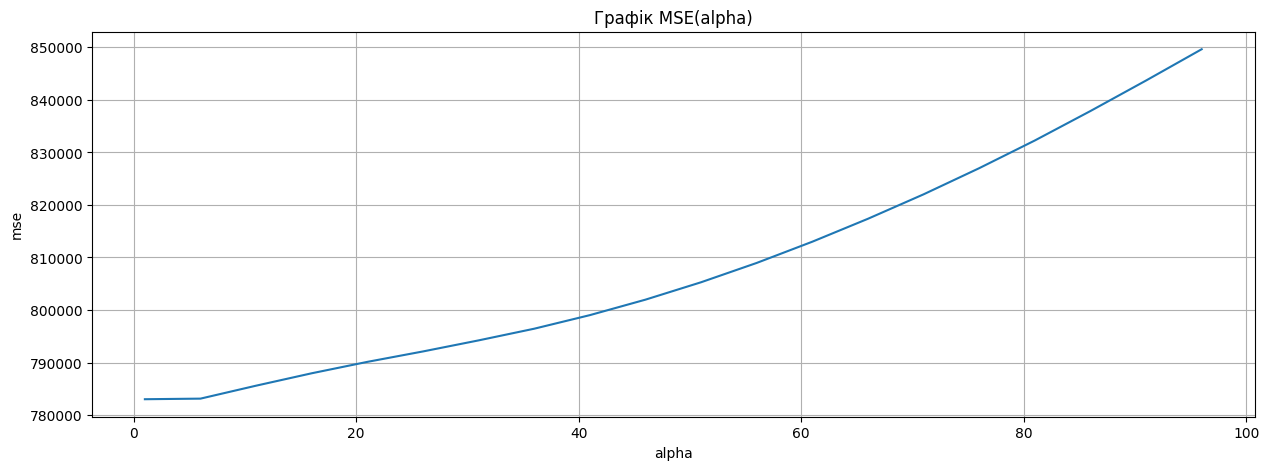

In [67]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas).fit(X, y)
mse = [i.mean() for i in regressor.mse_path_]

create_plot([regressor.alphas_, mse], "Графік MSE(alpha)", "alpha", "mse", (15, 5))

Отже, ми обрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Оберіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


alpha = 1, MSE = 691447.250787807
alpha = 11, MSE = 883471.1829425395
alpha = 1, MSE = 710110.1624117332
alpha = 26, MSE = 860737.405948872
alpha = 21, MSE = 750676.356779


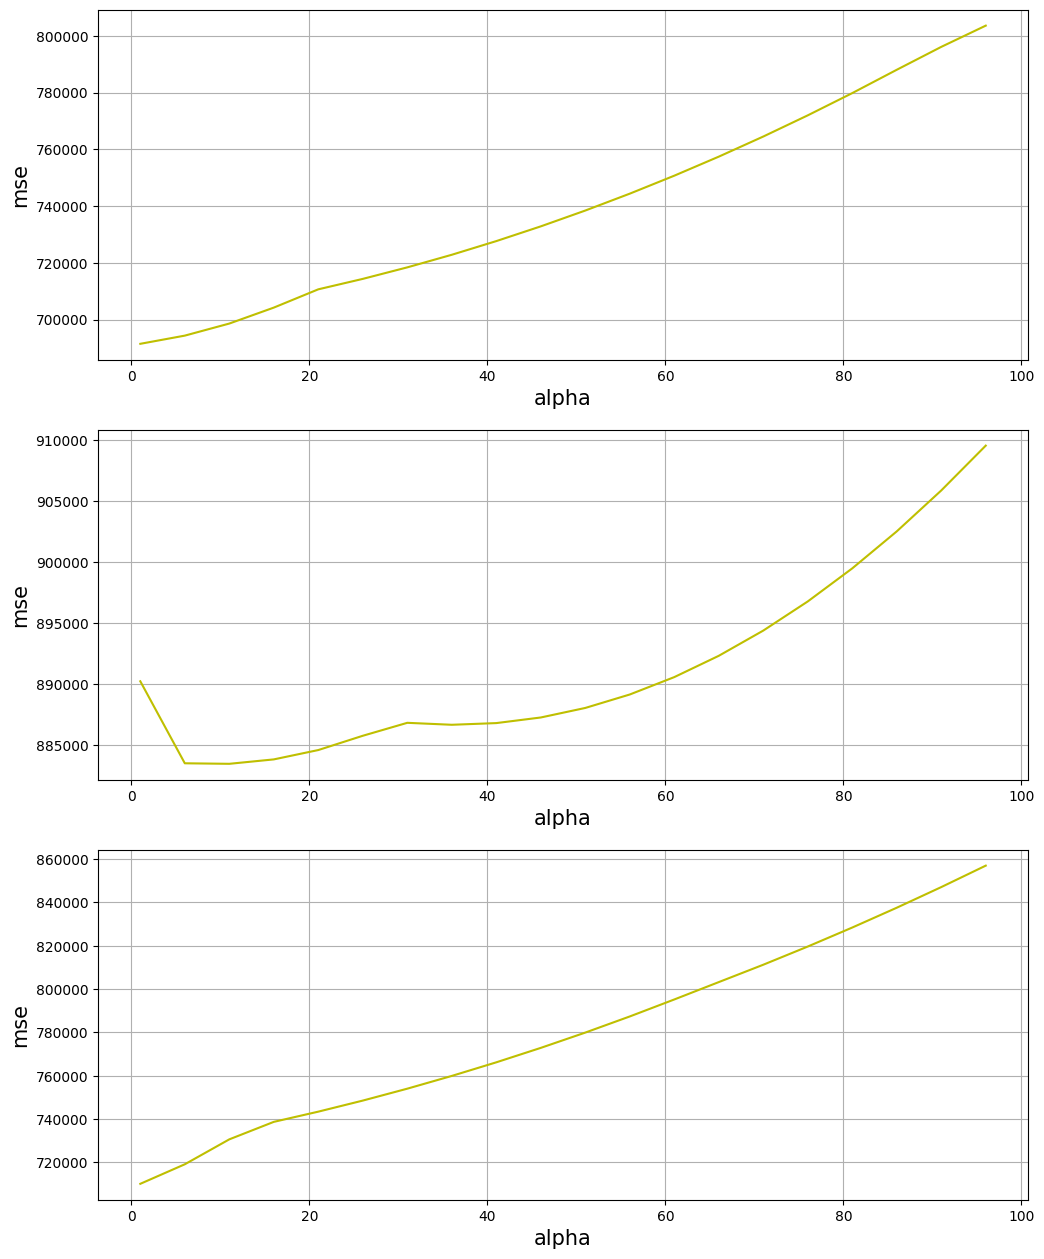

In [83]:
for i in range(3):
  plt.subplot(3, 1, i + 1)
  plt.rcParams["figure.figsize"] = (12, 10)
  plt.plot(regressor.alphas_, regressor.mse_path_[:, i], color="y")
  plt.subplots_adjust(top=1.3)
  plt.xlabel("alpha", fontsize=15)
  plt.ylabel("mse", fontsize=15)
  plt.grid()

for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
  alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
  print(f"alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}")

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні і тестові вибірки. При виборі `alpha` на крос-валідації ми обираємо щось "среднє", що буде давати прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__
1. Так, видно.
2. Так, логічно.

In [113]:
features_4 = sorted([i for i in zip(df.columns, regressor.coef_) if i[1] > 0], key=lambda x: x[1], reverse=True)
features_4

[('yr', 1019.4634940657196),
 ('atemp', 576.530793504555),
 ('season', 560.2416160308861),
 ('temp', 376.3632362096943),
 ('weekday', 137.34789390496314),
 ('workingday', 55.21237064135668)]

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__
1. Так.
2. Про ознаки weathersit та windspeed(mph) можна стверджувати, що при збільшенні їхніх величин, менше люедй беруть велосипеди. Що не скажеш про ознаку hum.

In [115]:
feature_3 = sorted([i for i in zip(df.columns, regressor.coef_) if i[1] < 0], key=lambda x: x[1])[:3]
feature_3

[('weathersit', -332.3698569623487),
 ('windspeed(mph)', -197.1396894024843),
 ('hum', -144.12915500348583)]

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

__Відповідь:__
1. windspeed(ms) єдина така ознака. Модель її викинула, бо, якщо подивитися на графік, можна помітити, що значення ознаки дуже близьке до 0.
2. З нульового значення можна зробити висновок, що це майже не впливає на попит на велосипеди.

In [117]:
feature_e = sorted([i for i in zip(df.columns, regressor.coef_) if -0.1 < i[1] < 0.1], key=lambda x: x[1])
feature_e

[('windspeed(ms)', -2.8051404183533485e-08)]

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, наскільки можна не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто відзначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів (1, 2, максимум 3), тому що для кожної допустимої комбінації нам доводиться кілька разів навчати модель. Такий процес займає багато часу, особливо якщо потрібно навчатися великих обсягах даних.